# Libraries is used for this CAPM model:

In [2]:
%matplotlib inline
from scipy import stats
import pandas as pd
import pandas_datareader as web    
import datetime
import matplotlib.pyplot as plt

# Financial data and preprocessing

## Get & check data from Yahoo Finance 

In [5]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2022,1,10)

In [7]:
import yfinance  as yf
df_spy = yf.download('SPY', start=start, end=end)
df_spy

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,88.454201,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,88.688362,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,88.750786,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,89.125427,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,89.422028,126402800
...,...,...,...,...,...,...
2022-01-03,476.299988,477.850006,473.850006,477.709991,470.083649,72668200
2022-01-04,479.220001,479.980011,475.579987,477.549988,469.926208,71178700
2022-01-05,477.160004,477.980011,468.279999,468.380005,460.902618,104538900


In [8]:
df_pfe = yf.download('PFE', start=start, end=end)
df_pfe

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,17.333965,17.969639,17.305504,17.960152,11.128053,54898644
2010-01-05,17.950665,17.960152,17.599621,17.703985,10.969335,45714931
2010-01-06,17.703985,17.846300,17.561670,17.647058,10.934059,43640975
2010-01-07,17.685009,17.713472,17.514231,17.580645,10.892910,41557112
2010-01-08,17.666035,17.751423,17.571157,17.722960,10.981088,32049716
...,...,...,...,...,...,...
2022-01-03,58.500000,58.549999,56.340000,56.650002,54.868088,57219200
2022-01-04,56.220001,56.430000,53.939999,54.529999,52.814774,66993100
2022-01-05,55.840000,56.439999,55.369999,55.630001,53.880169,52956400


In [9]:
rf = yf.download('^TNX','2010-1-1', '2022-1-10')
rf

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,3.859,3.859,3.808,3.841,3.841,0
2010-01-05,3.790,3.800,3.749,3.755,3.755,0
2010-01-06,3.771,3.837,3.761,3.808,3.808,0
2010-01-07,3.845,3.859,3.800,3.822,3.822,0
2010-01-08,3.843,3.851,3.775,3.808,3.808,0
...,...,...,...,...,...,...
2022-01-03,1.534,1.635,1.533,1.628,1.628,0
2022-01-04,1.663,1.686,1.654,1.668,1.668,0
2022-01-05,1.660,1.710,1.647,1.705,1.705,0


# Preliminary check of closing price trend (Chú thích ngoài lề)

### Note: Bởi vì trong khi giá đóng cửa (Close) chỉ đơn thuần đề cập đến giá vốn của cổ phiếu vào cuối ngày, giá đóng cửa được điều chỉnh (Adj Close) sẽ xem xét các yếu tố khác như cổ tức, chia tách cổ phiếu và các đợt chào bán cổ phiếu mới. Vì giá đóng cửa được điều chỉnh bắt đầu từ khi giá đóng cửa kết thúc, nên nó có thể được gọi là thước đo chính xác hơn trong việc xác định giá trị của cổ phiếu.

### Thực hiện quan sát sơ bộ xu hướng của dữ liệu: từ hình có thể thấy giá cổ phiếu và thị trường tăng trưởng tương quan thuận với nhau.

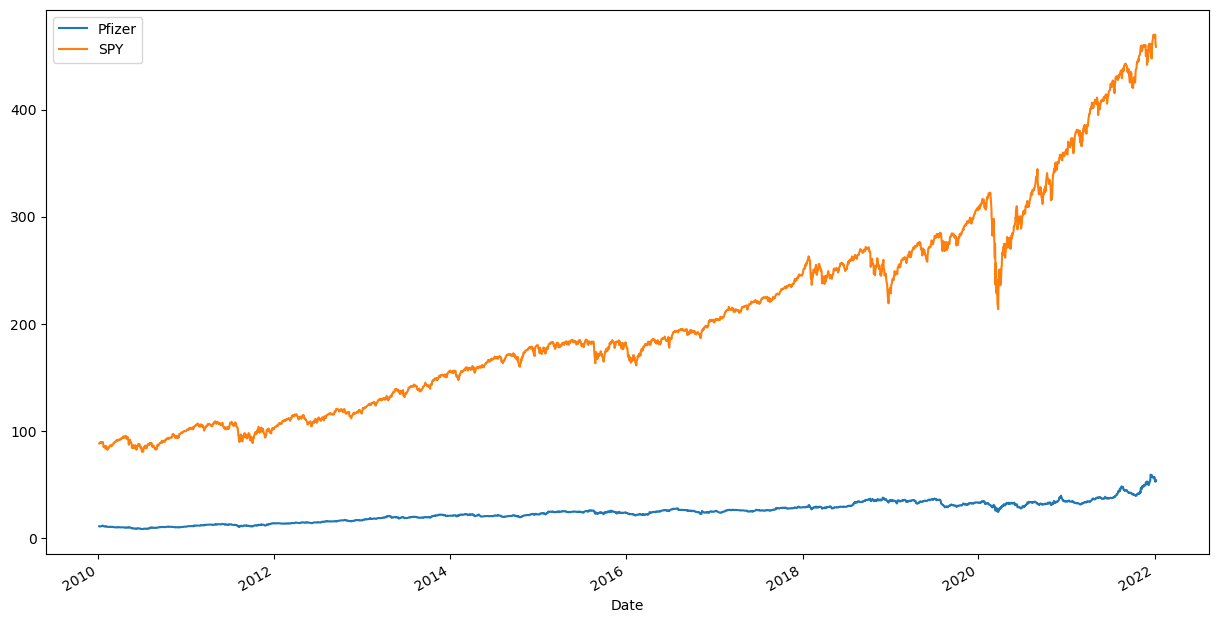

In [10]:
df_pfe['Adj Close'].plot(label = 'Pfizer', figsize=(15,8))
df_spy['Adj Close'].plot(label = 'SPY')
plt.legend()

### Và mức độ tăng trưởng cũng tương tự:

In [11]:
df_pfe['Cumu'] = df_pfe['Adj Close']/df_pfe['Adj Close'].iloc[0]
df_spy['Cumu'] = df_spy['Adj Close']/df_spy['Adj Close'].iloc[0]

<AxesSubplot:xlabel='Date'>

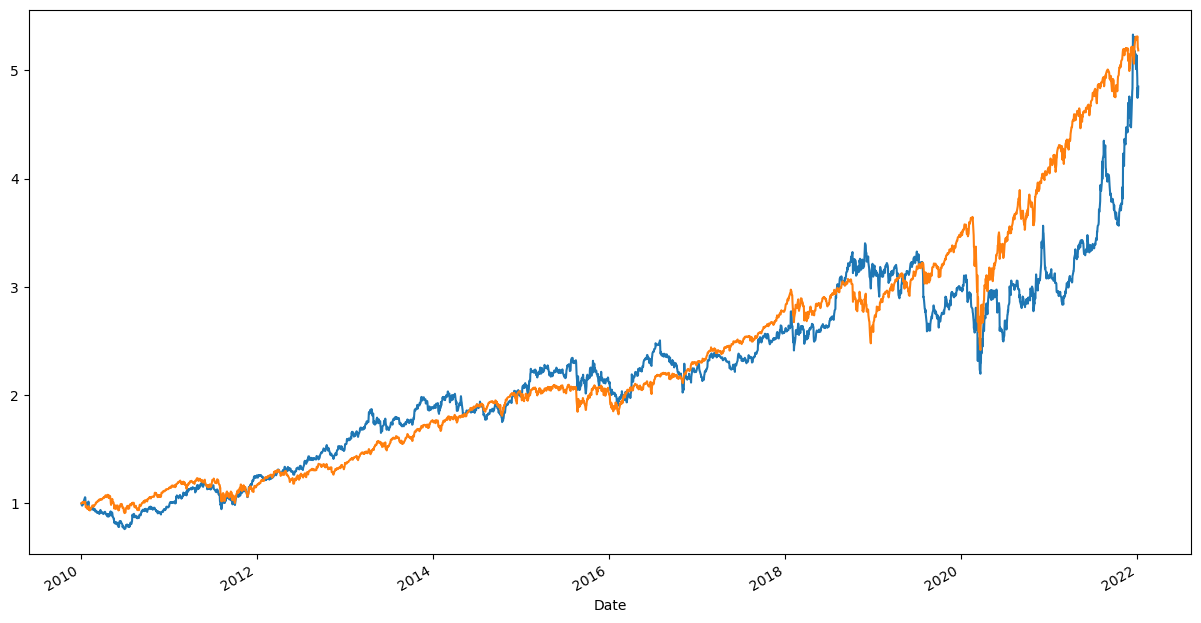

In [37]:
df_pfe['Cumu'].plot(label = 'Pfizer', figsize=(15,8))
df_spy['Cumu'].plot(label = 'SPY')

## Create the required dataset for the model (Clean data)

In [12]:
PFE = df_pfe.loc[:, ['Adj Close']]
SPY = df_spy.loc[:, ['Adj Close']]
rf = rf.loc[:, ['Adj Close']]


In [13]:
#Tính lợi tức hàng ngày của từng mã giao dịch
PFE['pfe_ret'] = PFE['Adj Close'].pct_change(1)
SPY['spy_ret'] = SPY['Adj Close'].pct_change(1)
rf['rf_r'] = rf['Adj Close'].pct_change(1)

In [14]:
# Xoá dòng chưa giá trị rỗng
PFE.dropna(axis=0, inplace=True)
SPY.dropna(axis=0, inplace=True)
rf.dropna(axis=0, inplace=True)

In [15]:
PFE.drop(['Adj Close'], axis = 1, inplace=True)
SPY.drop(['Adj Close'], axis = 1, inplace=True)
rf.drop(['Adj Close'], axis = 1, inplace=True)

In [16]:
merge_data = pd.merge(PFE, SPY, on='Date')
cleaned_data = pd.merge(merge_data, rf, on='Date')

In [17]:
# Export cleaned data to CSV files
cleaned_data.to_csv('Cleaned_data.csv')

In [18]:
cleaned_data

,pfe_ret,spy_ret,rf_r
Date,,,
2010-01-05,-0.014263,0.002647,-0.022390
2010-01-06,-0.003216,0.000704,0.014115
2010-01-07,-0.003763,0.004221,0.003676
2010-01-08,0.008095,0.003328,-0.003663
2010-01-11,0.008030,0.001397,0.002626
...,...,...,...
2022-01-03,-0.040643,0.005790,0.076720
2022-01-04,-0.037423,-0.000335,0.024570
2022-01-05,0.020172,-0.019202,0.022182


# Calculate alpha and beta values

In [19]:
#Tính phần bù rủi ro:
cleaned_data['rp_pfe'] = cleaned_data['pfe_ret'] - cleaned_data['rf_r']
cleaned_data['rp_spy'] = cleaned_data['spy_ret'] - cleaned_data['rf_r']

In [20]:
cleaned_data

,pfe_ret,spy_ret,rf_r,rp_pfe,rp_spy
Date,,,,,
2010-01-05,-0.014263,0.002647,-0.022390,0.008127,0.025037
2010-01-06,-0.003216,0.000704,0.014115,-0.017330,-0.013411
2010-01-07,-0.003763,0.004221,0.003676,-0.007440,0.000545
2010-01-08,0.008095,0.003328,-0.003663,0.011758,0.006991
2010-01-11,0.008030,0.001397,0.002626,0.005404,-0.001229
...,...,...,...,...,...
2022-01-03,-0.040643,0.005790,0.076720,-0.117363,-0.070930
2022-01-04,-0.037423,-0.000335,0.024570,-0.061993,-0.024905
2022-01-05,0.020172,-0.019202,0.022182,-0.002010,-0.041384


### Chạy hàm hồi quy thống kê của thư viện scipy để tính chỉ số beta và alpha:

In [21]:
hoiquy = stats.linregress(cleaned_data['rp_pfe'], cleaned_data['rp_spy'])
print(hoiquy)

LinregressResult(slope=0.8496352061355666, intercept=4.425927027620907e-05, rvalue=0.9287899649242718, pvalue=0.0, stderr=0.006169139384268077, intercept_stderr=0.000186827709139129)


Có thể thấy từ kết quả sau khi chạy hàm hồi quy tuyến tính cho dữ liệu, beta cần tìm chính là slope (hệ số góc của đường hồi quy) và alpha là intercept (hệ số chặn) và alpha cũng là hệ số rf cần tìm để tính CAPM.

In [22]:
beta, rf, r_value, p_value, std_error = hoiquy
print('Beta for Pfizer stock is {} and alpha is {}'.format(beta, rf))

Beta for Pfizer stock is 0.8496352061355666 and alpha is 4.425927027620907e-05


### => Alpha = rf = 3.52682 x e^(-5) = 0,0237635

# Calculate CAPM for Pfizer stock

### Vì đang xem xét cổ phiếu tại thời điểm mới nhất trong dữ liệu nên tỉ suất sinh lợi thị trường ngày 10/1/2022 sẽ được chọn:

In [23]:
rm = cleaned_data.loc['2022-01-07', 'spy_ret']
rm

-0.003953496494621178

### Tính Expected return cho cổ phiếu PFE:


In [24]:
ER_PFE = rf + (beta * (rm-rf)) 
print('The expected return of PFE stock is {}'.format(ER_PFE))

The expected return of PFE stock is -0.0033523747731120323
